## Basic operations with Atmospheric data on native grid

In [1]:
import xarray as xr
import numpy as np
import intake

eerie_cat=intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

model = 'ifs-fesom2-sr'
expid = 'hist-1950'  # 'highres-future-ssp245', 'hist-1950', 'eerie-control-1950', 'eerie-spinup-1950'
version = 'v20240304'    #
realm='atmos'  # 'ocean' , 'land', 'atmos'
gridspec = 'native' # 'native', 'gr025'

cat_data=eerie_cat['dkrz.disk.model-output'][model][expid][version][realm][gridspec]
print(list(cat_data))

# ds = cat_data['2D_daily_avg'].to_dask()
# ds

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


['2D_daily_avg', '2D_daily_max', '2D_daily_min', '2D_monthly_avg', '2D_monthly_max', '2D_monthly_min', '3D_daily_avg', '3D_monthly_avg', '3D_6hourly', '2D_6hourly_accumulated', '2D_6hourly_instant']


In [2]:
ds = cat_data['2D_daily_avg'].to_dask()
ds

<xarray.Dataset>
Dimensions:    (time: 23741, value: 6599680)
Coordinates:
    lat        (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
    lon        (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
  * time       (time) datetime64[ns] 1950-01-01T12:00:00 ... 2014-12-31T12:00:00
Dimensions without coordinates: value
Data variables: (12/43)
    cprate     (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    erate      (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    m10u       (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    m10v       (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    m2d        (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    m2sh       (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    ...         ...
    mtnlwrf    (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    mtnlwrfcs  (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    mtnswrf    (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    mtnswrfcs  (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    mtsfr      (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
    tprate     (time, value) float64 dask.array<chunksize=(2, 6599680), meta=np.ndarray>
Attributes: (12/36)
    edition:               2
    centre:                ecmf
    centreDescription:     European Centre for Medium-Range Weather Forecasts
    subCentre:             0
    history:               🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan...
    Conventions:           CF-1.7 CMIP-6.2
    ...                    ...
    parent_activity_id:    HighResMIP
    sub_experiment_id:     none
    experiment:            coupled historical 1950-2014
    source:                IFS-FESOM2-SR (2023): \naerosol: none, prescribed ...
    institution:           Alfred Wegener Institute, Helmholtz Centre for Pol...
    sub_experiment:        none

We need grid data

In [3]:
lon = ds.lon.values
lat = ds.lat.values

In [4]:
import matplotlib.pylab as plt

Simplest way to plot the data

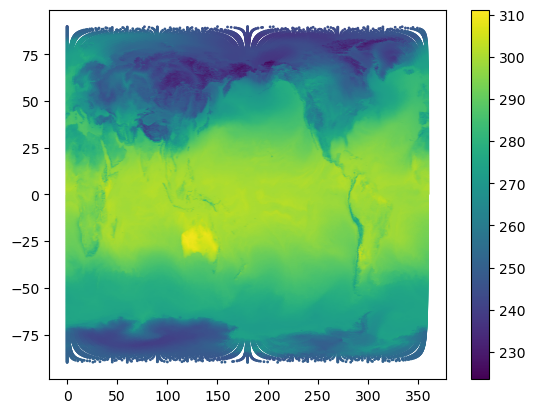

In [5]:
sstep = 10
plt.scatter(lon[::sstep], lat[::sstep], s=1, c=ds['mean2t'][0,::sstep])
plt.colorbar()

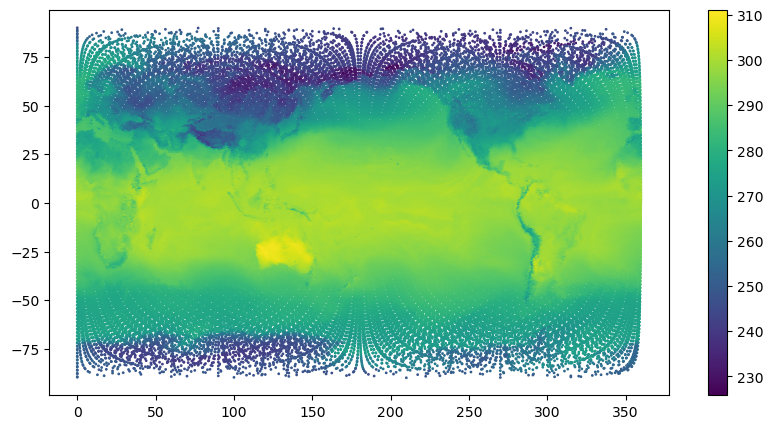

In [35]:
sstep = 50
plt.figure(figsize=(10,5))
plt.scatter(lon[::sstep], lat[::sstep], s=1, c=ds['mean2t'][0,::sstep])
plt.colorbar()

## Cut region

In [67]:
lon

array([  0.,  18.,  36., ..., 306., 324., 342.])

In [68]:
left = 120
right = 140
bottom = 30
top = 45

In [69]:
region = (lon < right) & (lon>left) & (lat > bottom) & (lat < top)

In [70]:
region

array([False, False, False, ..., False, False, False])

In [54]:
data_sample = ds['mean2t'][0,:].values

In [71]:
data_sample[region]

array([252.44763184, 252.07026672, 252.79792786, ..., 291.25222778,
       291.35922241, 291.50170898])

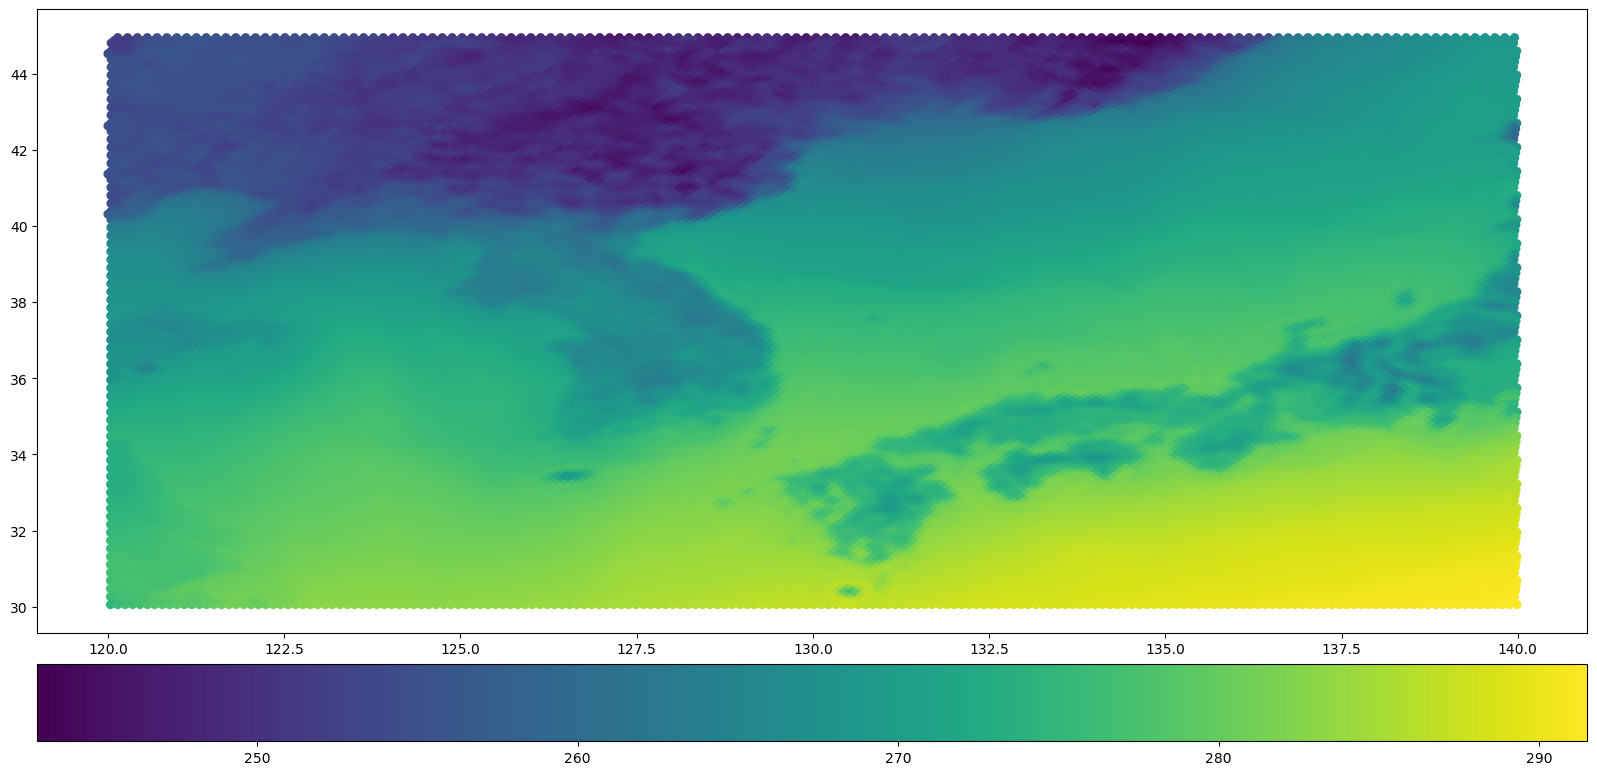

In [72]:

plt.figure(figsize=(20,10))
plt.scatter(lon[region], lat[region], s=30 , c=data_sample[region])
plt.colorbar(orientation='horizontal', pad=0.04)

In [73]:
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator

## Simple map with projection

In [74]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm

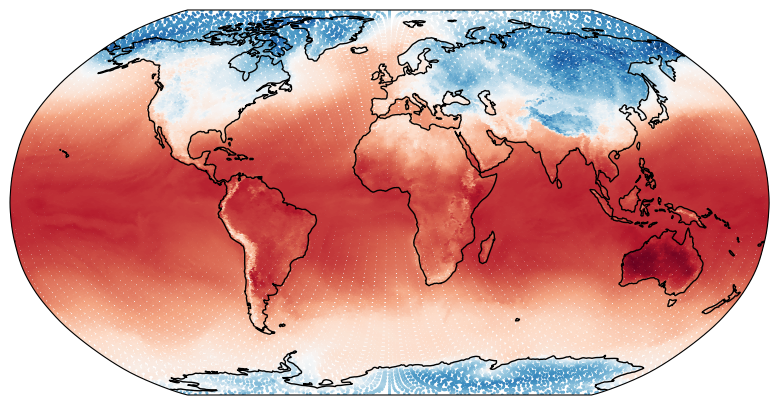

In [75]:
sstep = 50
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='110m', color='k')
ax.scatter(lon[::sstep], lat[::sstep], s=1 , c=data_sample[::sstep],
            cmap=cm.RdBu_r, transform=ccrs.PlateCarree())

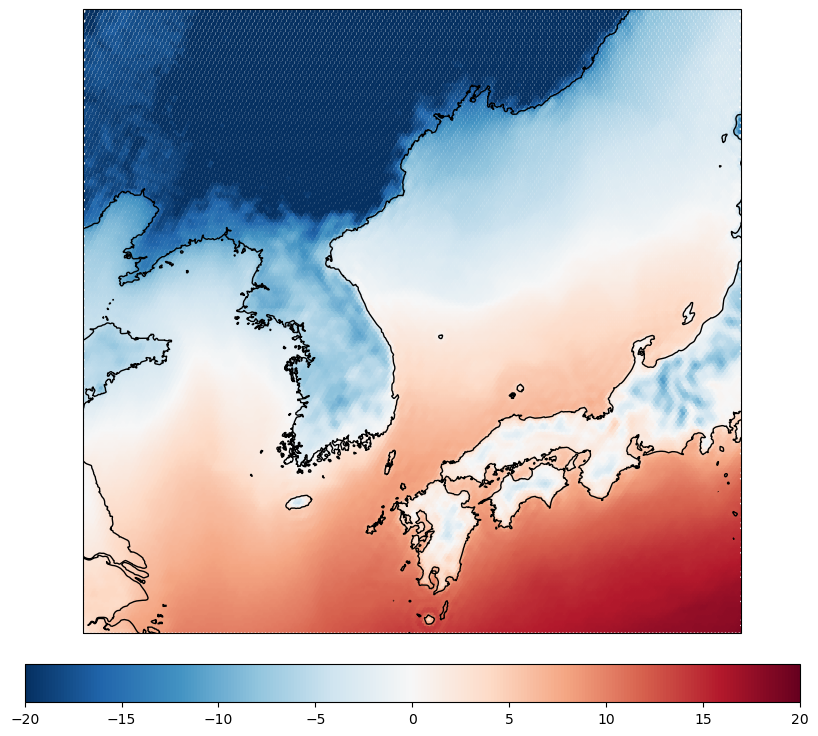

In [86]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='10m', color='k')
ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
mm = ax.scatter(lon[region], lat[region], s=5 , c=data_sample[region]-273, 
           vmin=-20, vmax=20,
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())
plt.colorbar(mm, orientation='horizontal', pad=0.04)

## Simple interpolation to a regular grid

In [113]:
lon_geo = np.linspace(120, 140, 160)
lat_geo = np.linspace(30, 45, 160)
lon_geo2, lat_geo2 = np.meshgrid(lon_geo, lat_geo)

In [114]:
points = np.vstack((lon, lat)).T

In [115]:
%%time
nn_interpolation = NearestNDInterpolator(points, data_sample)

CPU times: user 2.72 s, sys: 114 ms, total: 2.84 s
Wall time: 2.85 s


In [116]:
interpolated_nn = nn_interpolation((lon_geo2, lat_geo2))

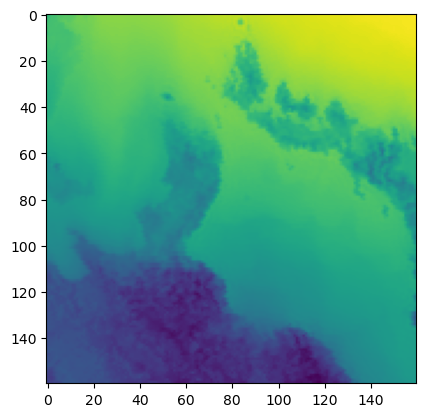

In [117]:
plt.imshow(interpolated_nn)

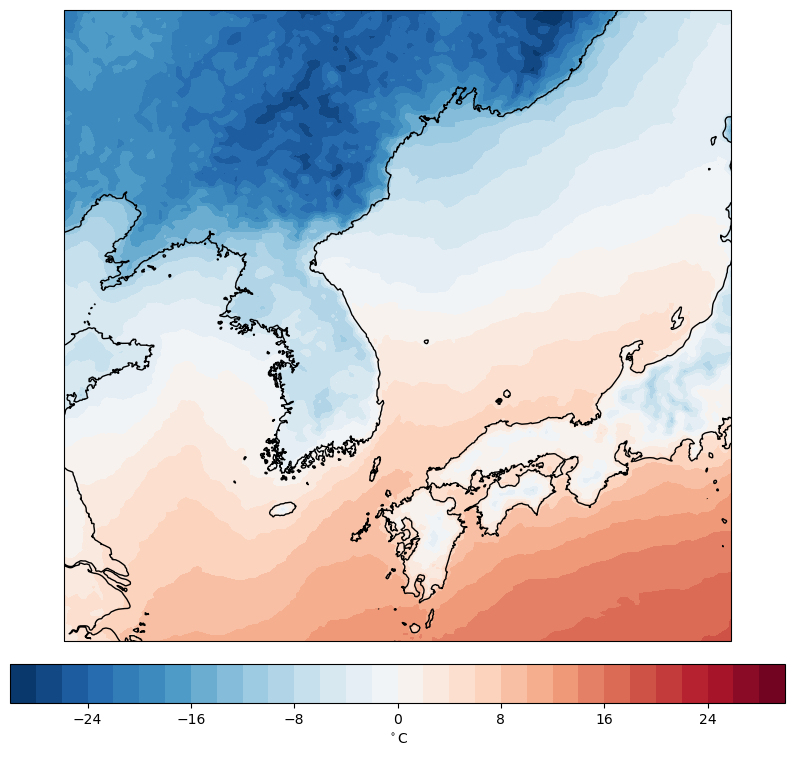

In [122]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='10m', color='k')
# ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
#ax.stock_img()
img = ax.contourf(lon_geo, lat_geo, interpolated_nn-273, 
           levels = np.linspace(-30,30,31),
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())
# ax.contour(lon_geo, lat_geo, interpolated_nn-273, 
#            levels = np.linspace(-30,30,31),
#            transform=ccrs.PlateCarree(), colors='k', linewidths=0.5)
#ax.add_feature(
#            cfeature.GSHHSFeature(levels=[1], scale="low", facecolor="lightgray")
#        )
#ax.stock_img()
# ax.add_feature(cfeature.OCEAN, zorder=10, edgecolor='black')
cbar = plt.colorbar(img, orientation='horizontal', pad=0.03)
cbar.set_label('$^\circ$C')

## Interpolate to grid from observations

In [123]:
obs_file = xr.open_dataset('/home/a/a270088/PYTHON/EERIE_hackathon_2023/COMMON/sst.mon.mean.nc')

In [124]:
obs_file

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1590)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1891-01-01 1891-02-01 ... 2023-06-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    title:            COBE Sea Surface Temperature Analysis
    history:          created June 2011 at ESRL/PSD using the grib data from ...
    platform:         Analyses
    original_source:  http://near-goos1.jodc.go.jp/cgi-bin/1997/near_goos_cat...
    Conventions:      CF-1.2
    institution:      NOAA ESRL/PSD
    comment:          recent values (w/i last year) may change as dataset is ...
    dataset_title:    COBE Sea Surface Temperature
    References:       https://www.psl.noaa.gov/data/gridded/data.cobe.html

In [126]:
lon_sst = obs_file.lon.data
lat_sst = obs_file.lat.data

lon_sst2, lat_sst2 = np.meshgrid(lon_sst, lat_sst)

In [127]:
data_on_obs_grid = NearestNDInterpolator(points, data_sample)(lon_sst2, lat_sst2)

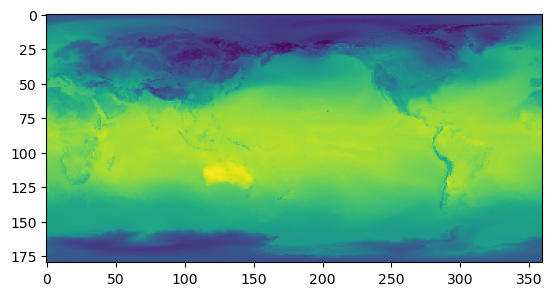

In [129]:
plt.imshow(data_on_obs_grid)

In [130]:
obs_sample = obs_file.sst.sel(time='2020-01').data[0,:,:]

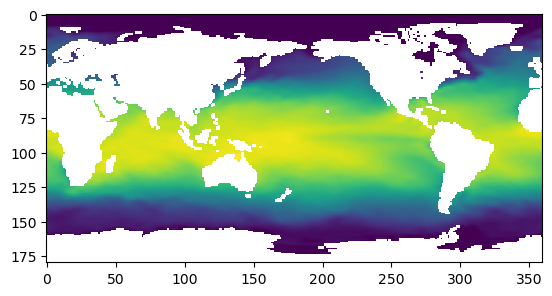

In [131]:
plt.imshow(obs_sample)

In [134]:
model_sst_sample = ds['msst'][0,:].values

In [135]:
model_sst_sample_on_obs_grid = NearestNDInterpolator(points, model_sst_sample)(lon_sst2, lat_sst2)

In [143]:
from matplotlib import cm

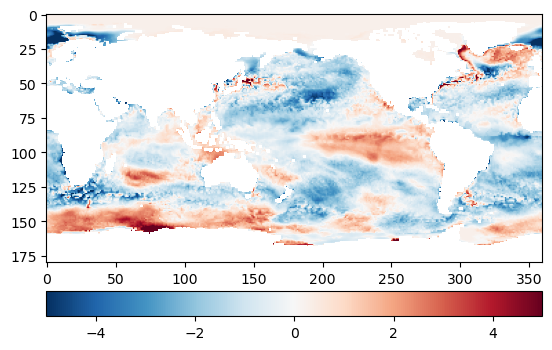

In [150]:
difference = (model_sst_sample_on_obs_grid-273)-obs_sample
plt.imshow(difference, vmin=-5, vmax=5, cmap=cm.RdBu_r)
plt.colorbar(orientation='horizontal', pad=0.08, )

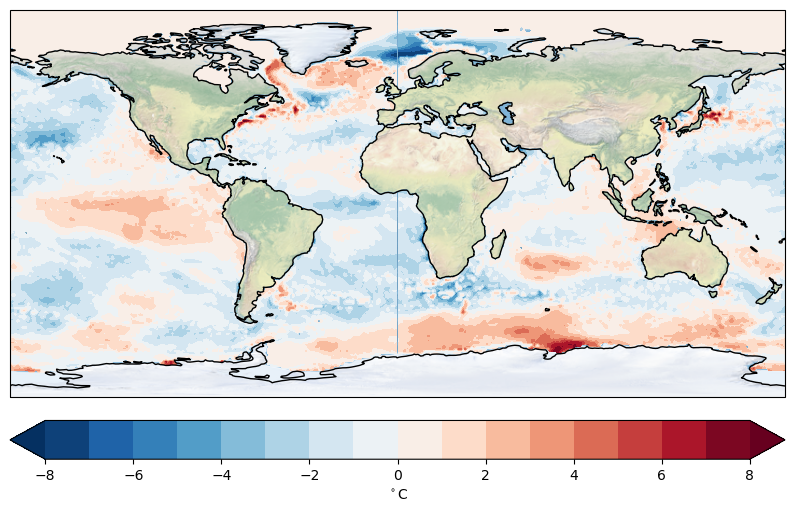

In [151]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m', color='k')
img = ax.contourf(lon_sst, lat_sst, difference, 
           levels = np.linspace(-8,8,17),
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree(), extend='both')
ax.stock_img()
cbar = plt.colorbar(img, orientation='horizontal', pad=0.03)
cbar.set_label('$^\circ$C')

## Point time series

In [152]:
def tunnel_fast1d(latvar, lonvar, lonlat):
    """
    Find closest point in a set of (lat,lon) points to specified pointd.
    Parameters:
    -----------
        latvar : ndarray
            1d array with lats
        lonvar : ndarray
            1d array with lons
        lonlat : ndarray
            2d array with the shape of [2, number_of_point],
            that contain coordinates of the points
    Returns:
    --------
        node : int
            node number of the closest point
    Taken from here http://www.unidata.ucar.edu/blogs/developer/en/entry/accessing_netcdf_data_by_coordinates
    and modifyed for 1d
    """

    rad_factor = np.pi / 180.0  # for trignometry, need angles in radians
    # Read latitude and longitude from file into numpy arrays
    latvals = latvar[:] * rad_factor
    lonvals = lonvar[:] * rad_factor

    # Compute numpy arrays for all values, no loops
    clat, clon = np.cos(latvals), np.cos(lonvals)
    slat, slon = np.sin(latvals), np.sin(lonvals)

    clat_clon = clat * clon
    clat_slon = clat * slon

    lat0_rad = lonlat[1, :] * rad_factor
    lon0_rad = lonlat[0, :] * rad_factor

    delX_pre = np.cos(lat0_rad) * np.cos(lon0_rad)
    delY_pre = np.cos(lat0_rad) * np.sin(lon0_rad)
    delZ_pre = np.sin(lat0_rad)

    nodes = np.zeros((lonlat.shape[1]))
    for i in range(lonlat.shape[1]):
        delX = delX_pre[i] - clat_clon
        delY = delY_pre[i] - clat_slon
        delZ = delZ_pre[i] - slat
        dist_sq = delX ** 2 + delY ** 2 + delZ ** 2
        minindex_1d = dist_sq.argmin()  # 1D index of minimum element
        node = np.unravel_index(minindex_1d, latvals.shape)
        nodes[i] = node[0]

    return nodes.astype('int')

In [160]:
# the point we are interesting in (Madrid as example)
lon_target = 129.0714
lat_target = 35.1731

In [161]:
points = np.array([[lat_target],[lon_target]])

In [162]:
index = tunnel_fast1d(lon, lat, points)
index[0] # index of Madrid in the 'value' dimension

1228828

In [163]:
# in the model, this is the point
lon[index[0]], lat[index[0]]

(129.03061224489795, 35.184533500486)

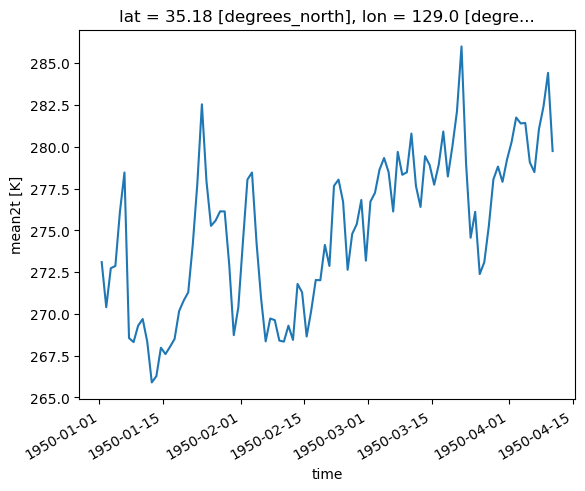

In [164]:
ds['mean2t'][0:100, index[0]].plot()

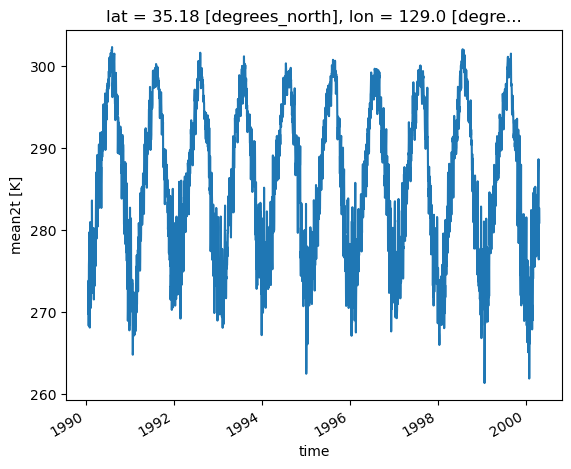

In [168]:
ds['mean2t'].sel(time=slice('1990-01-23','2000-04-23'))[:,index[0]].plot()